In [40]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *

In [41]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
reg_values = list(np.logspace(-4, -1, 6))
macro_configs = config_generator(L1_reg=reg_values,
                                 L2_reg=reg_values)
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [42]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 40000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = RFLO(rnn, alpha=alpha, L2_reg=params['L2_reg'], L1_reg=params['L1_reg'])
optimizer = SGD_Momentum(lr=0.01, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 1.0s 
Test loss: 0.08086161409409204 

Progress: 20.0% complete 
Time Elapsed: 2.1s 
Test loss: 0.0041504759014000915 

Progress: 30.0% complete 
Time Elapsed: 3.3s 
Test loss: 0.00697079300287311 

Progress: 40.0% complete 
Time Elapsed: 4.5s 
Test loss: 0.0032705582167541648 

Progress: 50.0% complete 
Time Elapsed: 5.6s 
Test loss: 0.0014173798441164173 

Progress: 60.0% complete 
Time Elapsed: 6.8s 
Test loss: 0.0012870783262440072 

Progress: 70.0% complete 
Time Elapsed: 8.0s 
Test loss: 0.0028694191129530295 

Progress: 80.0% complete 
Time Elapsed: 9.2s 
Test loss: 0.001150593607167366 

Progress: 90.0% complete 
Time Elapsed: 10.3s 
Test loss: 0.0011463499020360674 



In [43]:
test_sim = Simulation(rnn)
test_sim.run(data, mode='test', monitors=['rnn.loss_'], verbose=False)
processed_data = np.mean(test_sim.mons['rnn.loss_'])

In [12]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'pipeline_test'
job_name = 'lab_meeting_demo'
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py ../cluster_main_scripts/{}.py'.format(file_name, job_name))

In [14]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name))
submit_job('../job_scripts/{}.s'.format(job_name, n_jobs)

sending incremental file list
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/__pycache__/
vanilla-rtrl/cluster/__pycache__/start_jupyter_notebook.cpython-37.pyc
vanilla-rtrl/cluster/__pycache__/start_jupyter_notebook.cpython-38.pyc

sent 52,421 bytes  received 134 bytes  105,110.00 bytes/sec
total size is 1,211,666  speedup is 23.06
Submitted batch job 7636795


In [21]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7636767        cm  jupyter   oem214  R      11:30      1 cm27


In [22]:
configs_array, results_array, key_order, sim_dict = unpack_processed_data('../job_scripts/{}.s'.format(job_name))

In [38]:
def plot_2d_array_of_config_results(configs_array, results_array, key_order,
                                    log_scale=False):
    
    fig = plt.figure()

    plt.imshow(results_array.mean(-1))
    
    if log_scale:
        plt.yticks(range(results_array.shape[0]), np.round(np.log10(configs_array[key_order[0]]), 3))
        plt.xticks(range(results_array.shape[1]), np.round(np.log10(configs_array[key_order[1]]), 3))
    else:
        plt.yticks(range(results_array.shape[0]), np.round(configs_array[key_order[0]], 3))
        plt.xticks(range(results_array.shape[1]), np.round(configs_array[key_order[1]], 3))
        
    
    plt.ylabel(key_order[0])
    plt.xlabel(key_order[1])
    plt.colorbar()

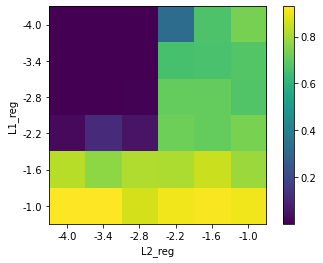

In [39]:
plot_2d_array_of_config_results(configs_array, results_array, key_order, log_scale=True)